## Exploration of the train file


### Columns names 
- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded Note that ip, app, device, os, and channel are encoded.

### Basic information on the data
- Number of rows: 184903890


- Os, channel, App_id seems a pretty good feature
- The label is pretty skewed (0:99.8% and 1:0.2%).
- IP does not really seems to be a good feature
- Device seems quite skewed (Maybe make a boolean feature of it ?)

### Initialize spark and load data

In [18]:
#Load packages
from pyspark.sql import SparkSession
import spark_df_profiling
from pyspark.sql import functions as F
from pyspark.sql import Window

In [12]:
#Other settings
%matplotlib inline

In [2]:
#Init the spark session
spark = SparkSession.builder\
               .appName("SparkSession")\
               .enableHiveSupport()\
               .getOrCreate()\


In [3]:
df = spark.read.csv(path="/home/siebert/projects/adtracking-fraud-detection/data/train.csv", header=True)
df.printSchema()
print(df.count())

root
 |-- ip: string (nullable = true)
 |-- app: string (nullable = true)
 |-- device: string (nullable = true)
 |-- os: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: string (nullable = true)

184903890


### Spark dataframe profiling

In [4]:
df = df.cache()
spark_df_profiling.ProfileReport(df=df,spark=spark)

Number of variables,8
Number of observations,184903890
Total Missing (%),12.5%
Total size in memory,0.0 B
Average record size in memory,0.0 B
Numeric,0
Categorical,8
Date,0
Text (Unique),0
Rejected,0
Distinct count,706


<b> Comments </b> <br/>
- Os, channel, App_id seems a pretty good feature
- The label is pretty skewed (0:99.8% and 1:0.2%). 
- IP does not really seems to be a good feature
- Device seems quite skewed (Maybe make a boolean feature of it ?)

## Explore the features
### Click time

In [7]:
df = df.withColumn("click_date",F.to_date(F.col("click_time")))
#Check the year
df.groupby(F.year("click_date")).count().show(25,False)
#Check the months
df.groupby(F.month("click_date")).count().show(25,False)
#Check the max values
df.groupby().agg(F.max("click_date"),F.min("click_date")).show()

+----------------+---------+
|year(click_date)|count    |
+----------------+---------+
|2017            |184903890|
+----------------+---------+

+-----------------+---------+
|month(click_date)|count    |
+-----------------+---------+
|11               |184903890|
+-----------------+---------+

+---------------+---------------+
|max(click_date)|min(click_date)|
+---------------+---------------+
|     2017-11-09|     2017-11-06|
+---------------+---------------+



It seems that it only the clickings between 06-11-2017 and 09-11-2017. So monthly, weekly and yearly features can not be used. Lets look at the difference in days and hours

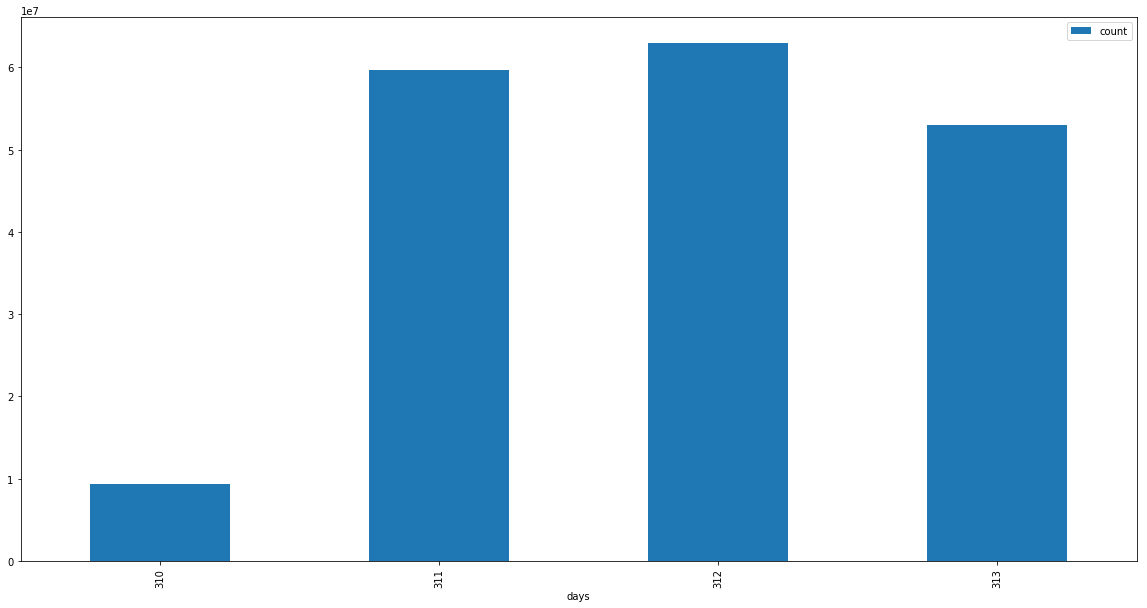

In [13]:
(df.groupby(F.dayofyear("click_time").alias("days")).count()
                   .toPandas()
                   .set_index("days")
                   .sort_index()
                   .plot(kind="bar",figsize=(20,10))
)

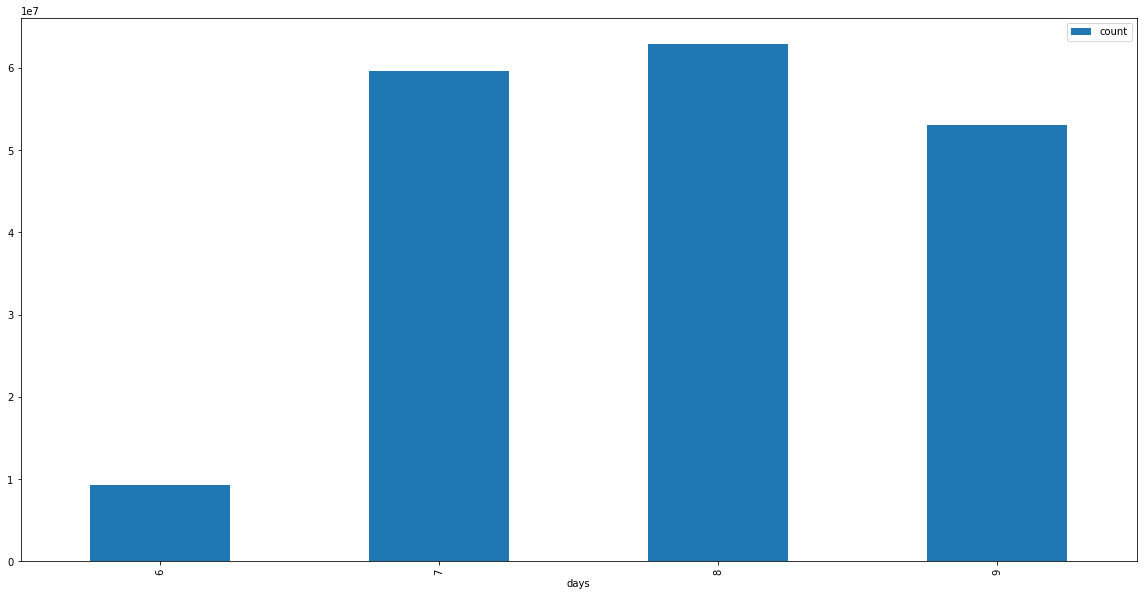

In [14]:
(df.groupby(F.dayofmonth("click_time").alias("days")).count()
                   .toPandas()
                   .set_index("days")
                   .sort_index()
                   .plot(kind="bar",figsize=(20,10))
)

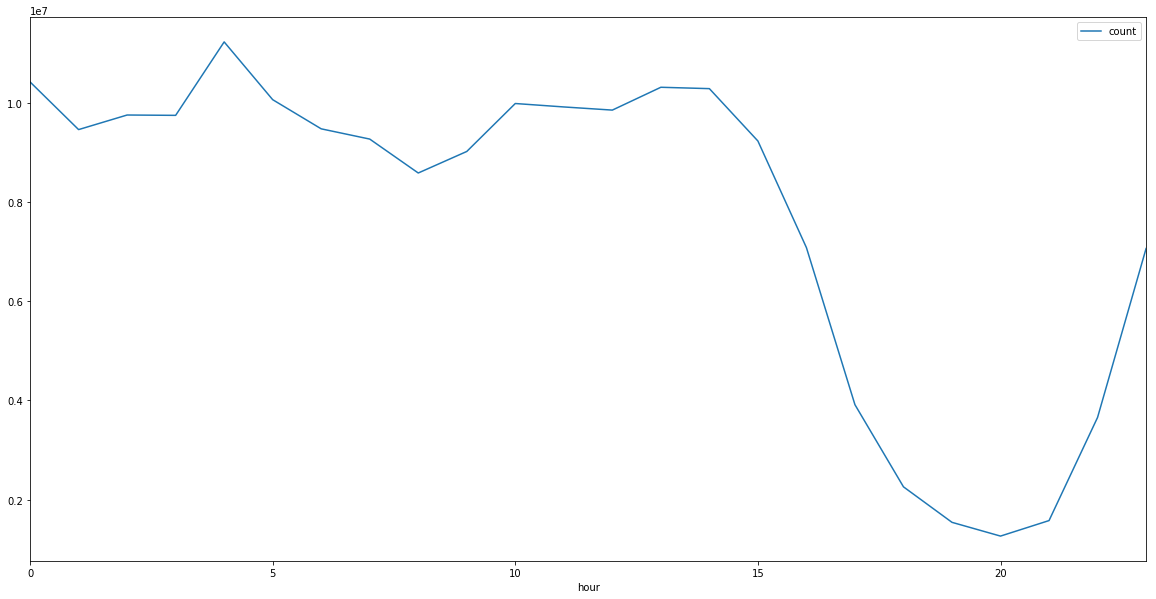

In [15]:
(df.groupby(F.hour("click_time").alias("hour")).count()
                   .toPandas()
                   .set_index("hour")
                   .sort_index()
                   .plot(figsize=(20,10))
)

## Explore the feature division groupby of the label

### label = 'is_attributed'

In [ ]:
#Check also the conversion rate over the hour. Look if there is a difference.
(df.groupby(F.hour("click_time").alias("hour")).pivot("is_attributed").count()
                   .fillna(0)
                   .withColumn("perc_0",F.col("0")/(F.col("0") + F.col("1")))
                   .withColumn("perc_1",F.col("1")/(F.col("0") + F.col("1")))
                   .toPandas()
                   .set_index("hour")
                   .sort_index()
                   .plot(figsize=(20,10))
)

## Check click delta between ip address and channel combination.


In [ ]:
window = Window.partitionBy("ip","channel").orderBy("click_time")

df_delta = df.withColumn("click_delta",F.datediff(F.col("click_time"),F.lag(F.col("click_time")).over(window)))
